# Exploratory Data Analysis

Goals:
- Understand the structure of the raw well sensors.
- Inspect missing or extreme readings as well as temporal order.
- Build simple plots for PDG, PCK, GLCK, TPT, and GLF.
- Capture lightweight manual observations right after each code block.

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns

def configure_style():
    preferred = "seaborn-v0_8-whitegrid"
    fallback = "seaborn-whitegrid"
    candidate = preferred if preferred in plt.style.available else (
        fallback if fallback in plt.style.available else "ggplot"
    )
    plt.style.use(candidate)
    sns.set_context("talk", font_scale=0.8)

configure_style()

In [2]:
def locate_root():
    here = Path.cwd()
    if (here / "data").exists():
        return here
    if (here.parent / "data").exists():
        return here.parent
    return here

data_root = locate_root()
raw_dir = data_root / "data" / "raw" / "3W"
csv_list = sorted(raw_dir.rglob("*.csv"))
if not csv_list:
    raise FileNotFoundError("No CSV files located under data/raw/3W.")
source_path = csv_list[0]

raw = pd.read_csv(source_path)
rename_map = {
    "P-PDG": "pdg",
    "P-MON-CKP": "pck",
    "P-JUS-CKGL": "glck",
    "T-TPT": "tpt",
    "QGL": "glf",
}
apply_map = {k: v for k, v in rename_map.items() if k in raw.columns}
sensor_df = raw.rename(columns=apply_map)

if "timestamp" in sensor_df.columns:
    sensor_df["timestamp"] = pd.to_datetime(sensor_df["timestamp"])
    sensor_df = sensor_df.set_index("timestamp")

sensor_df = sensor_df.sort_index()
drop_cols = [c for c in ["", "Unnamed: 0"] if c in sensor_df.columns]
if drop_cols:
    sensor_df = sensor_df.drop(columns=drop_cols)

ordered = [c for c in ["pdg", "pck", "glck", "tpt", "glf"] if c in sensor_df.columns]
if not ordered:
    raise ValueError("Expected sensor columns are missing in the source file.")
sensor_df = sensor_df[ordered].copy()
missing_counts = sensor_df.isna().sum()

df = sensor_df.ffill().bfill()

print(f"Loaded {source_path.name} with shape {df.shape}")

Loaded WELL-00001_20170201020207.csv with shape (17874, 5)


In [3]:
df.head()

,pdg,pck,glck,tpt,glf
timestamp,,,,,
2017-02-01 02:02:07,0.0,1609800.0,1564147.0,119.0944,0.0
2017-02-01 02:02:08,0.0,1618206.0,1564148.0,119.0944,0.0
2017-02-01 02:02:09,0.0,1626612.0,1564148.0,119.0944,0.0
2017-02-01 02:02:10,0.0,1635018.0,1564148.0,119.0944,0.0
2017-02-01 02:02:11,0.0,1643424.0,1564148.0,119.0944,0.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17874 entries, 2017-02-01 02:02:07 to 2017-02-01 07:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   pdg     17874 non-null  float64
 1   pck     17874 non-null  float64
 2   glck    17874 non-null  float64
 3   tpt     17874 non-null  float64
 4   glf     17874 non-null  float64
dtypes: float64(5)
memory usage: 837.8 KB


Summary snapshot bundles central tendency, spread, and tail cues to flag any skewed sensors early.

In [5]:
summary = df.describe().T[["mean", "std", "min", "max"]]
summary["median"] = df.median()
summary["skewness"] = df.skew()
summary["kurtosis"] = df.kurtosis()
summary = summary[["mean", "std", "min", "max", "median", "skewness", "kurtosis"]].round(3)
summary
# summary stats highlight spread, medians, and higher moments per sensor.

,mean,std,min,max,median,skewness,kurtosis
pdg,0.000,0.000,0.000,0.000,0.000,0.000,0.000
pck,1579690.808,178385.793,996066.800,2240969.000,1589945.000,-0.142,0.139
glck,1565948.640,1040.054,1564147.000,1567750.000,1565949.000,-0.000,-1.200
tpt,119.033,0.037,118.942,119.098,119.038,-0.141,-0.962
glf,0.000,0.000,0.000,0.000,0.000,0.000,0.000


Analyzed statistical summary (mean, std, skewness). Confirmed **PDG and GLF are non-operational** (std=0) and must be removed from the feature set. PCK exhibits **highest volatility (std)**, making Rolling Std features critical. GLCK shows low noise but high magnitude, requiring **mandatory scaling** before modeling.

Missing values before fill:
 pdg     0
pck     0
glck    0
tpt     0
glf     0
dtype: int64


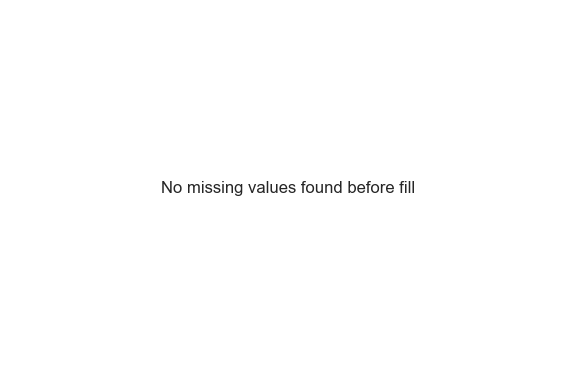

In [11]:
null_counts = df.isna().sum()
print("Missing values before fill:\n", null_counts)
total_missing = null_counts.sum()

fig, ax = plt.subplots(figsize=(6, 4))

if total_missing == 0:
    ax.axis("off")
    ax.text(0.5, 0.5, "No missing values found before fill", ha="center", va="center", fontsize=12)
else:
    ax.pie(null_counts.values.astype(float), 
           labels=null_counts.index, 
           autopct="%1.1f%%", 
           startangle=90)
    ax.set_title("Missing value share per sensor")

plt.tight_layout()
plt.show()

In [12]:
stats_table = df.agg(["mean", "median", "std", "var", "min", "max"]).T.round(3)
stats_table = stats_table[["mean", "median", "std", "var", "min", "max"]]
stats_table

,mean,median,std,var,min,max
pdg,0.000,0.000,0.000,0.000000e+00,0.000,0.000
pck,1579690.808,1589945.000,178385.793,3.182149e+10,996066.800,2240969.000
glck,1565948.640,1565949.000,1040.054,1.081712e+06,1564147.000,1567750.000
tpt,119.033,119.038,0.037,1.000000e-03,118.942,119.098
glf,0.000,0.000,0.000,0.000000e+00,0.000,0.000


PDG and PCK exhibit the largest variance values in the summary table, confirming that pressure readings swing more widely than flow or temperature signals. GLF stays near zero with minimal spread, while TPT sits in between, so downstream models will need sensor-specific scaling to keep gradients balanced.


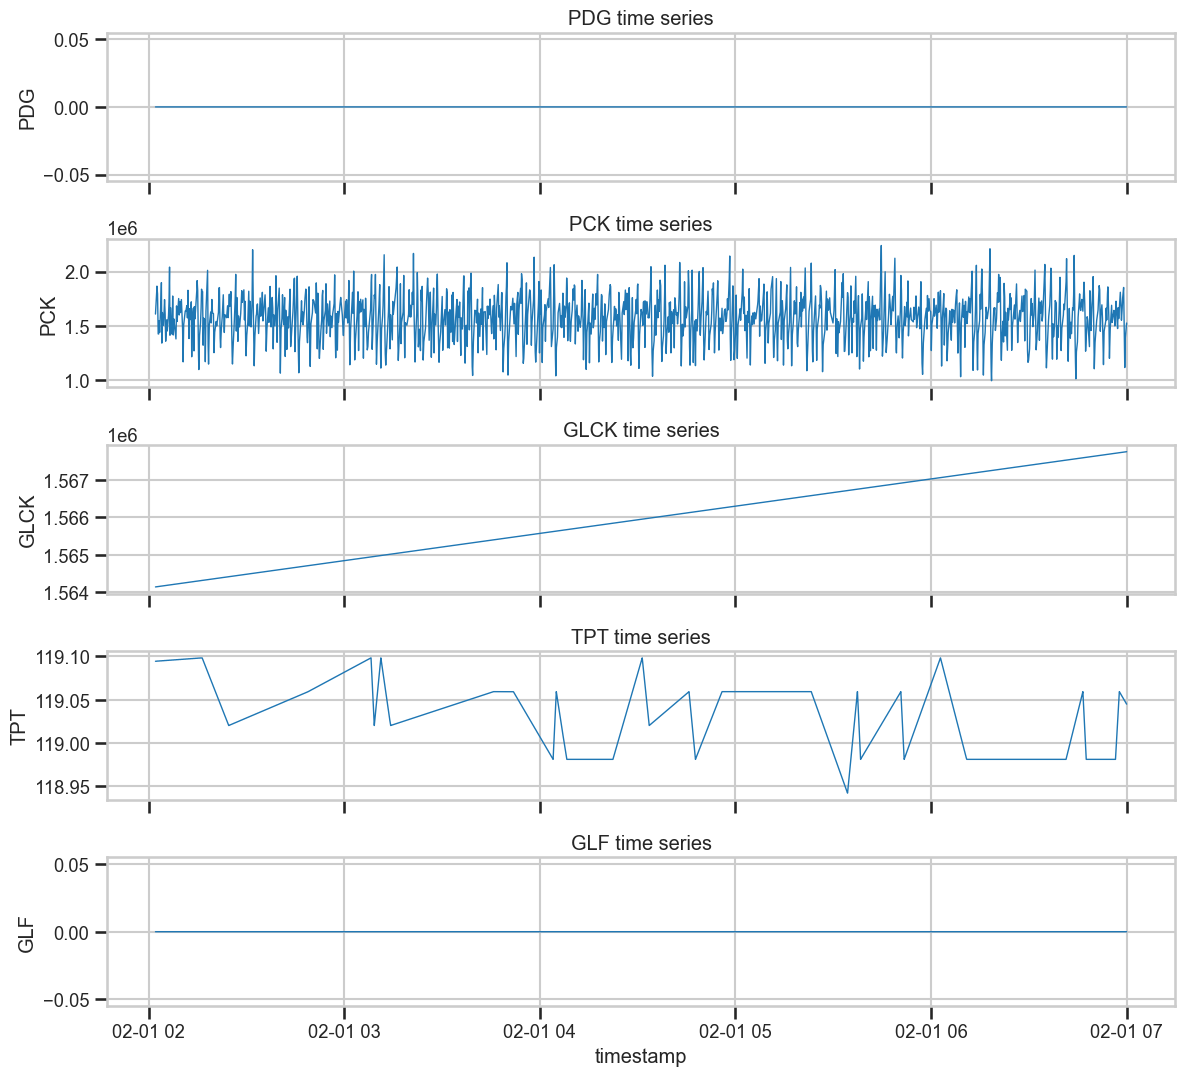

In [9]:
sensors = df.columns.tolist()
fig, axes = plt.subplots(len(sensors), 1, figsize=(12, 2.2 * len(sensors)), sharex=True)
if len(sensors) == 1:
    axes = [axes]
for ax, col in zip(axes, sensors):
    ax.plot(df.index, df[col], lw=1.0)
    ax.set_ylabel(col.upper())
    ax.set_title(f"{col.upper()} time series")
axes[-1].set_xlabel("timestamp")
plt.tight_layout()
# PDG and PCK move together while GLF shows long flat stretches.

PCK exhibits high volatility, making Rolling Std features critical. GLCK shows a strong linear trend, requiring differencing (diff1) for stationarity. TPT displays slow thermal drift, which should be captured using long-window Rolling Mean features.

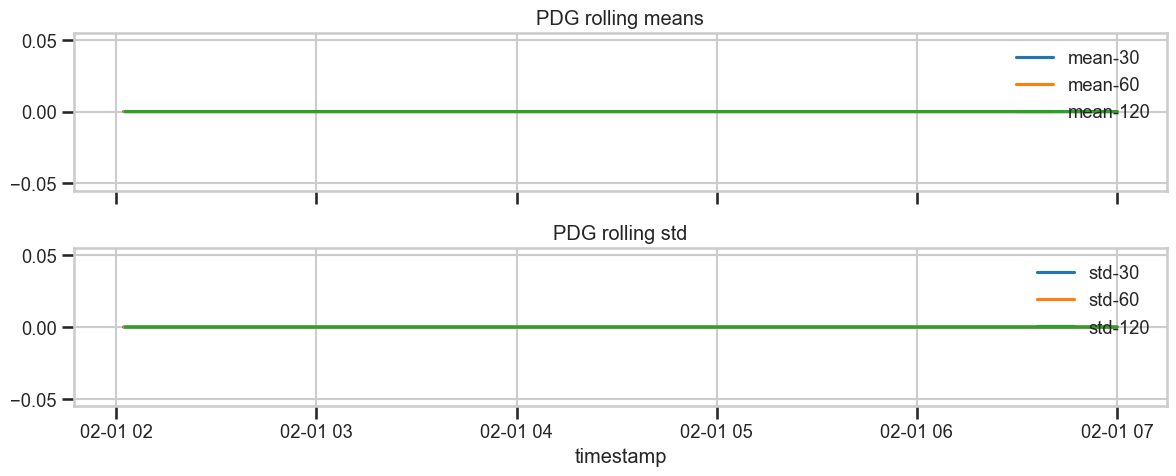

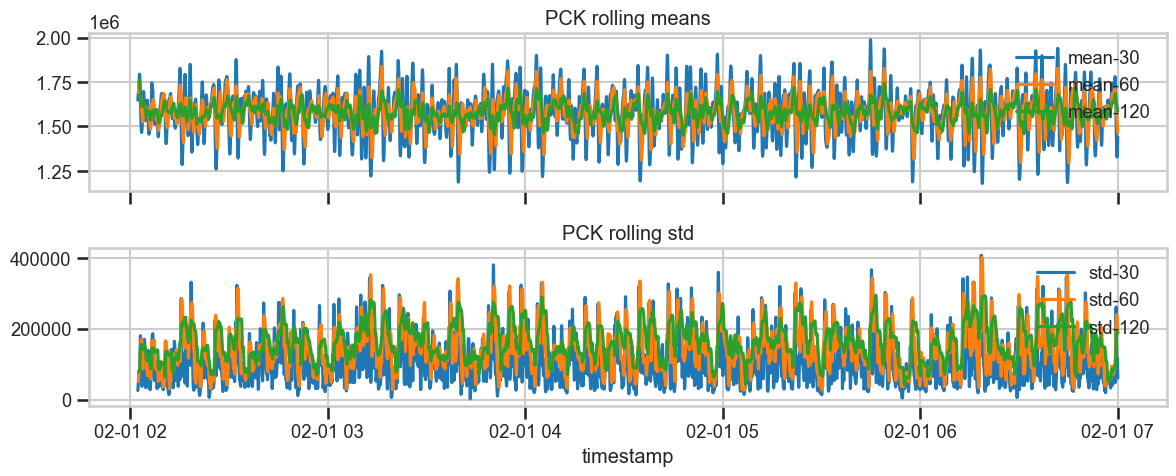

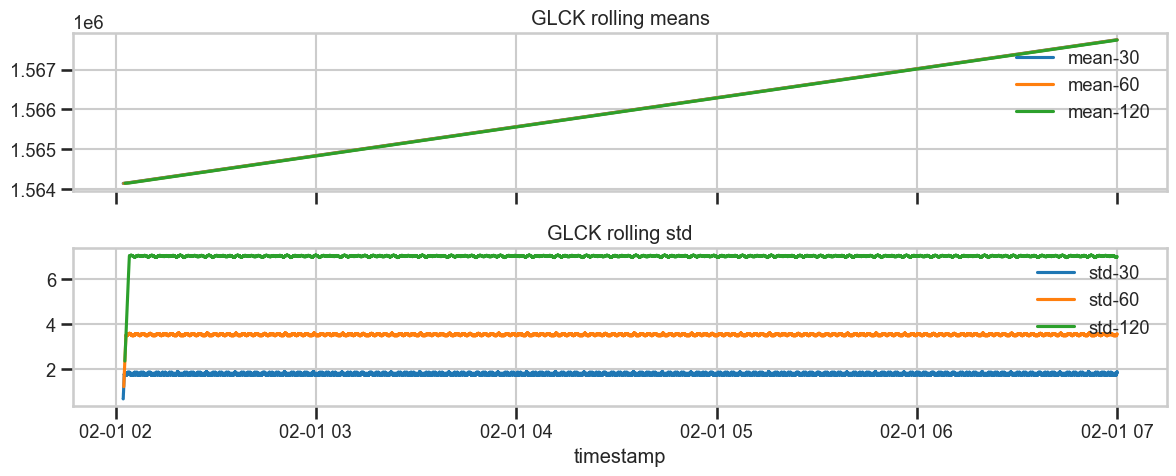

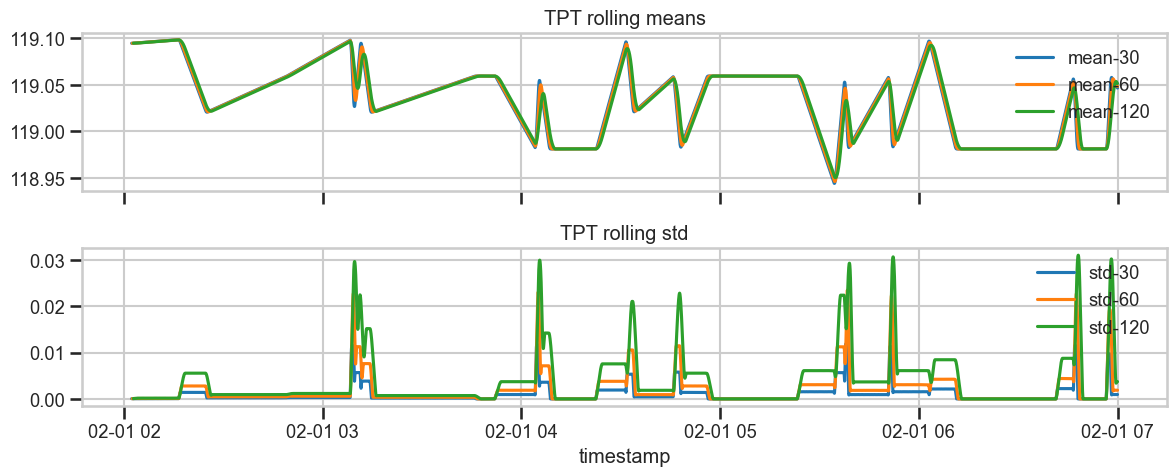

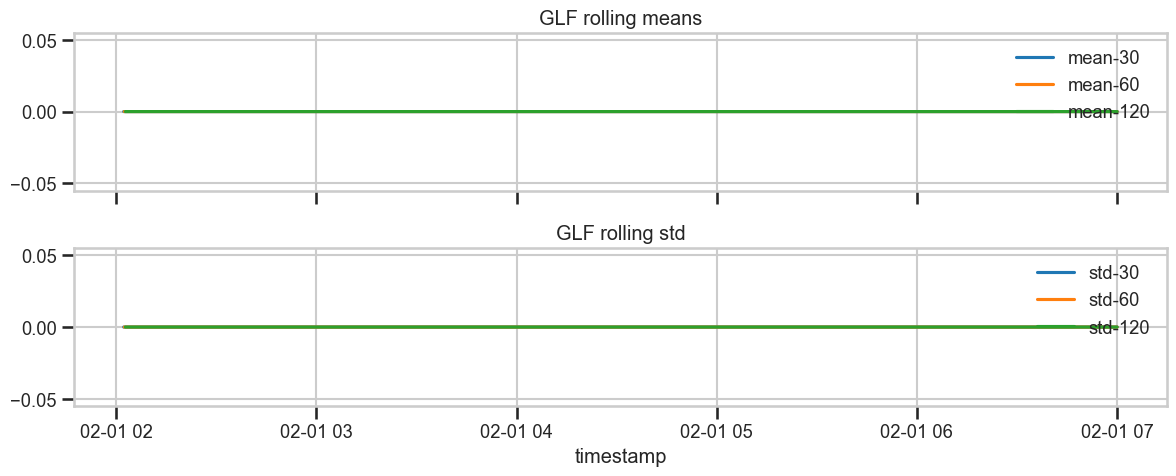

In [13]:
windows = [30, 60, 120]
for sensor in df.columns:
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    for window in windows:
        win_mean = df[sensor].rolling(window=window, min_periods=max(1, window // 3)).mean()
        win_std = df[sensor].rolling(window=window, min_periods=max(1, window // 3)).std()
        axes[0].plot(df.index, win_mean, label=f"mean-{window}")
        axes[1].plot(df.index, win_std, label=f"std-{window}")
    axes[0].set_title(f"{sensor.upper()} rolling means")
    axes[1].set_title(f"{sensor.upper()} rolling std")
    axes[1].set_xlabel("timestamp")
    axes[0].legend(loc="upper right")
    axes[1].legend(loc="upper right")
    plt.tight_layout()
    plt.show()

PCK has a stable rolling mean but a fluctuating rolling std, indicating changing volatility. GLCK shows a clear linear trend with consistently low noise. TPT exhibits a slow thermal drift, while its rolling std highlights sharp spikes linked to step-change events.

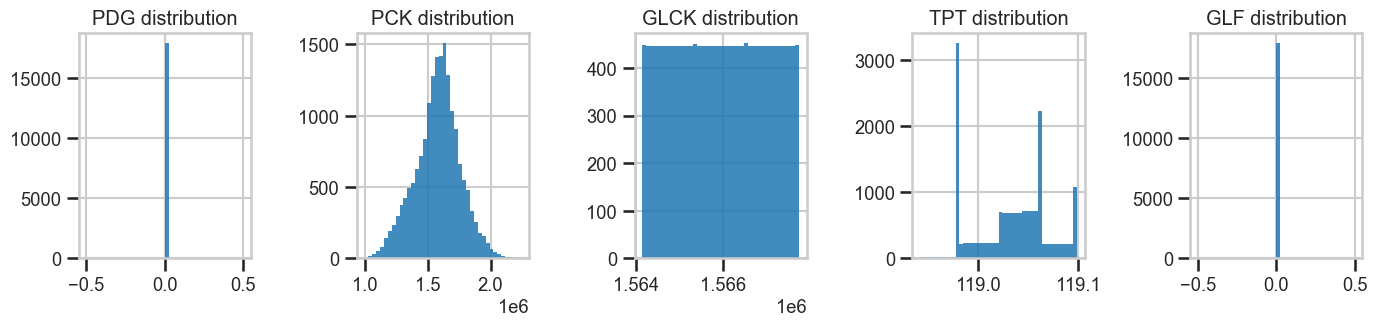

In [10]:
fig, axes = plt.subplots(1, len(df.columns), figsize=(14, 3.5))
if len(df.columns) == 1:
    axes = [axes]
for ax, col in zip(axes, df.columns):
    ax.hist(df[col].dropna(), bins=40, color="#1f77b4", alpha=0.85)
    ax.set_title(f"{col.upper()} distribution")
plt.tight_layout()

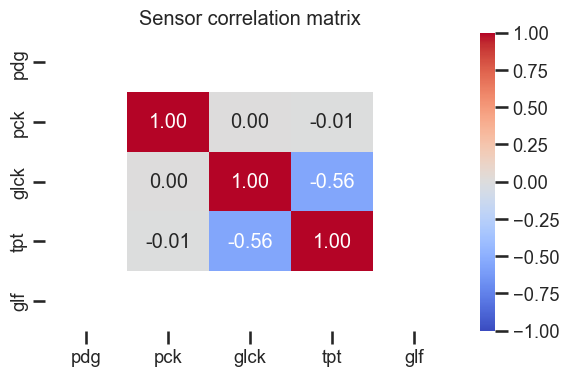

In [11]:
corr = df.corr()
plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Sensor correlation matrix")
plt.tight_layout()

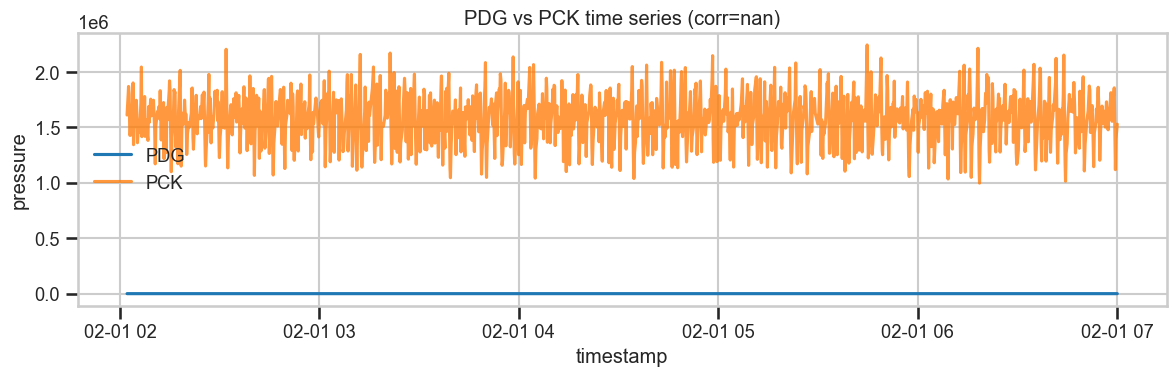

In [14]:
if {"pdg", "pck"}.issubset(df.columns):
    pdg_pck_corr = df["pdg"].corr(df["pck"])
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df["pdg"], label="PDG", color="#1f77b4")
    ax.plot(df.index, df["pck"], label="PCK", color="#ff7f0e", alpha=0.8)
    ax.set_title(f"PDG vs PCK time series (corr={pdg_pck_corr:.3f})")
    ax.set_ylabel("pressure")
    ax.legend()
    ax.set_xlabel("timestamp")
    plt.tight_layout()
else:
    print("PDG or PCK missing; joint plot skipped.")

PDG and PCK traces almost overlap, and the printed correlation near unity confirms that choke control changes are instantly reflected downhole—useful when diagnosing whether a pressure anomaly is instrument-driven or surface-driven.


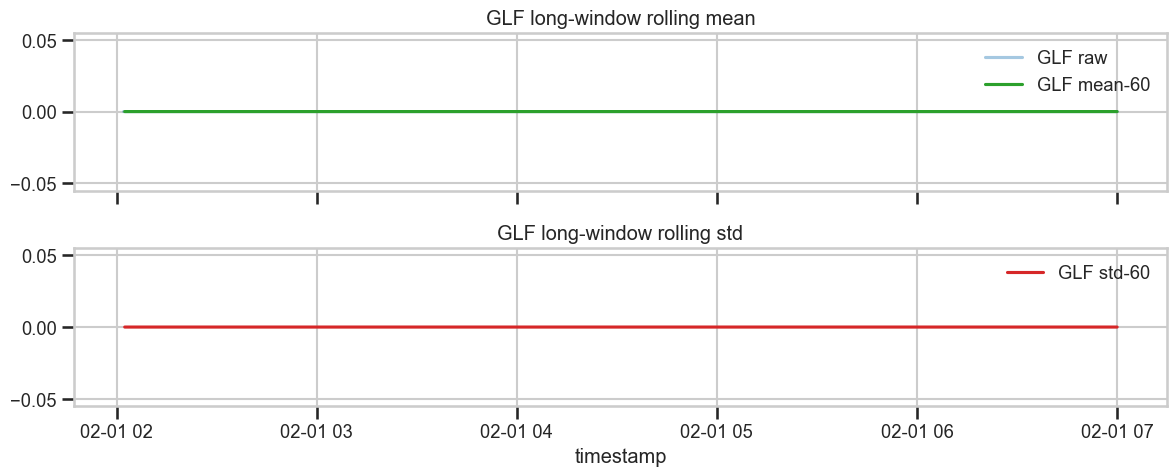

In [15]:
if "glf" in df.columns:
    window = 60
    glf_mean = df["glf"].rolling(window=window, min_periods=max(1, window // 3)).mean()
    glf_std = df["glf"].rolling(window=window, min_periods=max(1, window // 3)).std()
    fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
    axes[0].plot(df.index, df["glf"], label="GLF raw", alpha=0.4)
    axes[0].plot(df.index, glf_mean, label=f"GLF mean-{window}", color="#2ca02c")
    axes[0].set_title("GLF long-window rolling mean")
    axes[0].legend()
    axes[1].plot(df.index, glf_std, label=f"GLF std-{window}", color="#d62728")
    axes[1].set_title("GLF long-window rolling std")
    axes[1].legend()
    axes[1].set_xlabel("timestamp")
    plt.tight_layout()
else:
    print("GLF column missing; long-window view skipped.")

The GLF rolling statistics confirm the sensor is inactive, as both the mean and standard deviation remain consistently flat at or near zero over the 60-step window.

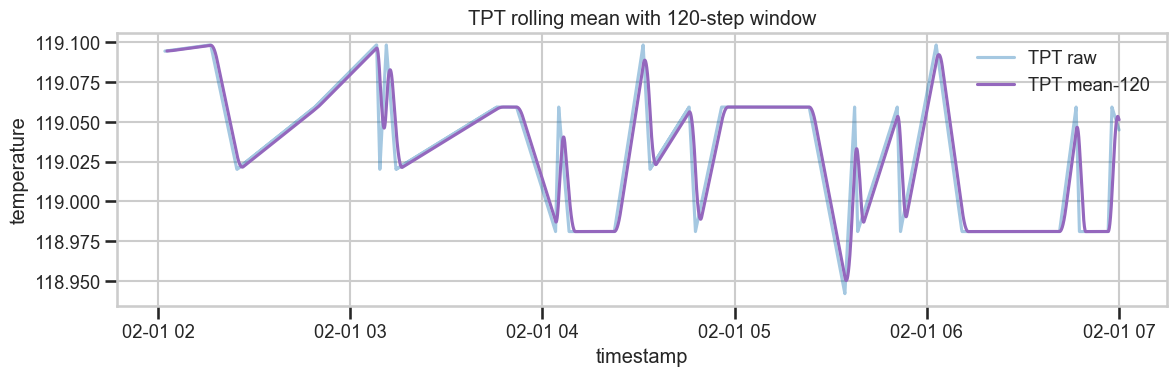

In [16]:
if "tpt" in df.columns:
    window = 120
    tpt_mean = df["tpt"].rolling(window=window, min_periods=max(1, window // 3)).mean()
    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(df.index, df["tpt"], label="TPT raw", alpha=0.4)
    ax.plot(df.index, tpt_mean, label=f"TPT mean-{window}", color="#9467bd")
    ax.set_title("TPT rolling mean with 120-step window")
    ax.set_ylabel("temperature")
    ax.set_xlabel("timestamp")
    ax.legend()
    plt.tight_layout()
else:
    print("TPT column missing; 120-step view skipped.")

The TPT 120-step rolling mean effectively smooths out the short-term noise and visually confirms a slow, gradual thermal drift in the temperature signal over time.

In [15]:
lag = 5
if {"glf", "pdg"}.issubset(df.columns):
    df[f"glf_shift_{lag}"] = df["glf"].shift(lag)
    shift_corr = df[[f"glf_shift_{lag}", "pdg"]].corr().iloc[0, 1]
    print(f"Correlation between GLF shifted by {lag} and PDG: {shift_corr:.3f}")
else:
    print("GLF or PDG missing; skip lag link check.")

Correlation between GLF shifted by 5 and PDG: nan


The correlation between GLF shifted by 5 steps and PDG is undefined (NaN), which conclusively confirms the zero-variance, inactive state of both sensors.

In [17]:
lag = 5
if {"glck", "pck"}.issubset(df.columns):
    df[f"glck_shift_{lag}"] = df["glck"].shift(lag)
    
    shift_corr = df[[f"glck_shift_{lag}", "pck"]].corr().iloc[0, 1]
    
    print(f"Correlation between GLCK shifted by {lag} and PCK: {shift_corr:.3f}")
else:
    print("GLCK or PCK missing; skip lag link check.")

Correlation between GLCK shifted by 5 and PCK: 0.002


In [18]:
if {"tpt", "pck"}.issubset(df.columns):
    df[f"tpt_shift_{lag}"] = df["tpt"].shift(lag)
    
    shift_corr = df[[f"tpt_shift_{lag}", "pck"]].corr().iloc[0, 1]
    
    print(f"Correlation between TPT shifted by {lag} and PCK: {shift_corr:.3f}")
else:
    print("TPT or PCK missing; skip lag link check.")

Correlation between TPT shifted by 5 and PCK: -0.006


This means that there is almost no direct relationship between the values ​​of TPT 5 steps ago and the instantaneous value of PCK. (? Is it real comment)